In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Ensure we can import from 'core'
sys.path.append(os.getcwd()+'/..')

from src.environment import LigandEnvironment, NormalConcentration
from src.physics import Receptor
from objectives.loss import InformationLoss

# Initialize the environment

In [3]:
# 1. SETUP
# ----------------------------------------------------------------
# A single receptor (homopentamer) and a single ligand family
n_units = 1
n_families = 1
k_sub = 5
batch_size = 2048 # Large batch for good histograms

device = "cpu" # CPU is fine for plotting

# A. Environment (Concentration ~ Normal(5, 1))
conc_model = NormalConcentration(n_families, init_mean=5.0, init_scale=1.0)
env = LigandEnvironment(n_units, n_families, conc_model).to(device)
with torch.no_grad():
    # adjust sigma to make it narrow
    env.interaction_log_sigma.copy_(torch.tensor([[[-5.,-5.]]]))



## Sample concentrations and energies

In [5]:
with torch.no_grad():
    # Step 1: Sample
    energies, concs, _ = env.sample_batch(batch_size)
# Convert to numpy
c_data = concs.numpy()

Text(0.5, 0, '$E_\\text{close}$')

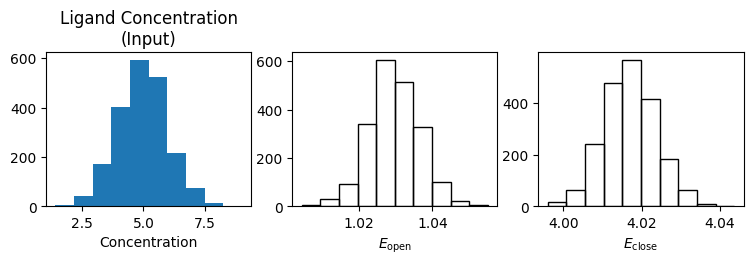

In [9]:
# 4. PLOTTING
# ----------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(3*3, 2))

# Panel A: Concentration Distribution
axes[0].hist(c_data)
axes[0].set_title(f"Ligand Concentration\n(Input)")
axes[0].set_xlabel("Concentration")

# Panel B: Energy Difference Distribution (E_open - E_closed)
axes[1].hist(energies[:,0,0],fill=False)
axes[1].set_xlabel(r"$E_\text{open}$")

axes[2].hist(energies[:,0,1],fill=False)
axes[2].set_xlabel(r"$E_\text{close}$")

A good channel should have a dissociation rate larger in the close than open state, ie binding promote opening. With the dissociation rate $K_i = \exp(\beta \Delta E_i)$
$$
K_c > K_o \Rightarrow E_c > E_o
$$

In [ ]:
# B. Physics
physics = Receptor(n_units, k_sub).to(device)


In [ ]:
# sample
with torch.no_grad():
    # Step 1: Sample
    energies, concs, _ = env.sample_batch(batch_size)
    
    # Step 2: Physics
    activity = physics(energies, concs, receptor_indices)

# ----------------------------------------------------------------
# Convert to numpy
c_data = concs.numpy()

a_data = activity.squeeze().numpy()

Text(0.5, 0, '$\\Delta E$ (kT)')

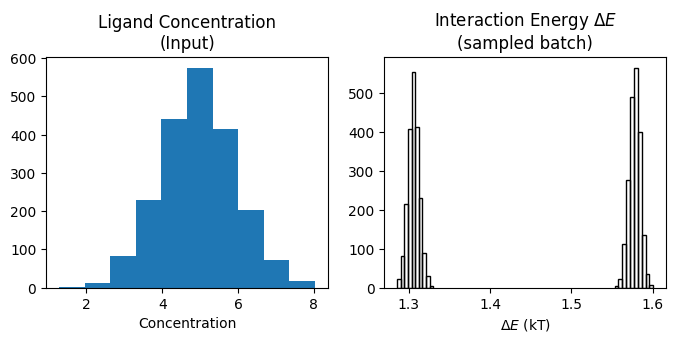

In [ ]:
# Define Receptor: Unit 0 repeated 5 times
receptor_indices = torch.zeros(1, k_sub, dtype=torch.long, device=device)
# C. Loss (to compute entropy)
loss_fn = InformationLoss()

In [ ]:
with torch.no_grad():
    epss = physics.epsilon_units[receptor_indices].sum(dim=1).unsqueeze(0)
    print(physics._compute_p_open(energies,concs,epss))


tensor([3.6766, 4.8903, 6.6807,  ..., 5.8019, 6.6636, 4.5605])
tensor([[nan, nan, nan,  ..., nan, nan, nan]])


In [23]:
print(energies)
#print(env.interaction_log_sigma)


tensor([[[1.3159, 1.5764]],

        [[1.3147, 1.5807]],

        [[1.3067, 1.5745]],

        ...,

        [[1.3218, 1.5717]],

        [[1.3207, 1.5808]],

        [[1.3128, 1.5792]]])


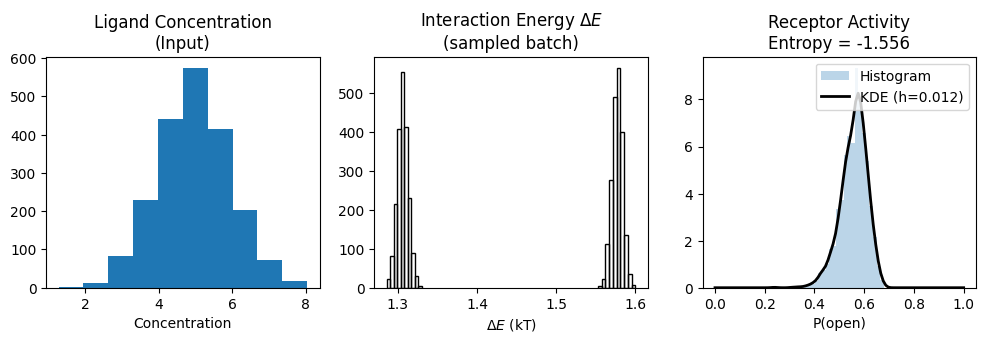

In [ ]:


# Panel C: Activity + KDE Check
axes[2].hist(a_data, bins=30, alpha=0.3, label='Histogram',density=True)

# -- Overlay the actual KDE used by the Loss Function --
# We evaluate the KDE on a grid [0, 1] to see what the optimizer "sees"
x_grid = torch.linspace(0, 1, 100).view(-1, 1) # (100, 1) query points

# Re-compute KDE manually for the grid
# Using the same bandwidth logic as InformationLoss
std = activity.std()
h = 1.06 * std * (batch_size ** (-0.2))
h = max(h.item(), 1e-4) # Safety


density = loss_fn._compute_kde(activity,x_grid)

# Vectorized KDE on grid
# activity shape: (N,) -> (1, N)
# grid shape: (M, 1)
#diffs = x_grid - activity.view(1, -1) # (M, N)
#gaussian = torch.exp(-0.5 * (diffs / h)**2) / (np.sqrt(2 * np.pi))
#density = gaussian.sum(dim=1) / (batch_size * h) # (M,)

axes[2].plot(x_grid.numpy(), density.numpy(), 'k-', lw=2, label=f'KDE (h={h:.3f})')
axes[2].set_title(f"Receptor Activity\nEntropy = {entropy_val:.3f}")
axes[2].set_xlabel("P(open)")
#axes[2].set_xlim(-0.1, 1.1)
axes[2].legend()
#axes[2].set_yscale('log')